In [2]:
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
GOT = pd.read_excel('/Users/dheepan.ramanan/Documents/GameOfThrones/DataTransform/GOTlinesDF.xlsx')

In [4]:
print GOT.head(5)
GOT.shape

     index               EpisodeName Character  \
250      0  The Wars to Come Script     MELARA   
251      1  The Wars to Come Script     CERSEI   
252      2  The Wars to Come Script     MELARA   
253      3  The Wars to Come Script     CERSEI   
254      4  The Wars to Come Script     MELARA   

                                   Line  LineLength     Setting  \
250     We shouldn’t be out here alone.          32  EXT. WOODS   
251                            Why not?           9  EXT. WOODS   
252               If your father hears…          22  EXT. WOODS   
253   He’ll never know we’ve been gone.          34  EXT. WOODS   
254                But if he finds out…          21  EXT. WOODS   

     SettingCountEpisode  EpisodeNumber  SeasonSceneCount           Source  \
250                    1              1                 1  Game Of Thrones   
251                    1              1                 1  Game Of Thrones   
252                    1              1                 1  Gam

(3073, 17)

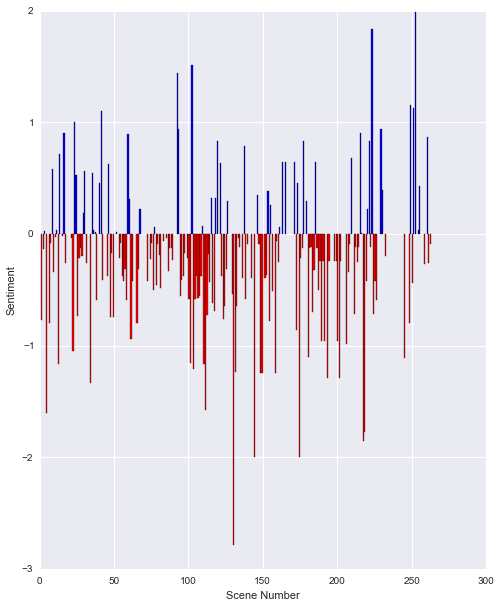

In [5]:

sentimentTrend = GOT.groupby('SeasonSceneCount').mean().reset_index()
mask1 = sentimentTrend["WeightedSentiment"]> 0
mask2 = sentimentTrend["WeightedSentiment"]< 0
plt.figure(figsize=(8, 10))
plt.bar(sentimentTrend[mask1].SeasonSceneCount, sentimentTrend[mask1].WeightedSentiment, color="Blue")
plt.bar(sentimentTrend[mask2].SeasonSceneCount, sentimentTrend[mask2].WeightedSentiment, color="Red")
plt.ylabel('Sentiment')
plt.xlabel('Scene Number')
plt.show()



/Users/dheepan.ramanan/anaconda/lib/python2.7/site-packages/matplotlib/transforms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=np.float_).reshape(2, 2)
/Users/dheepan.ramanan/anaconda/lib/python2.7/site-packages/matplotlib/transforms.py:1895: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


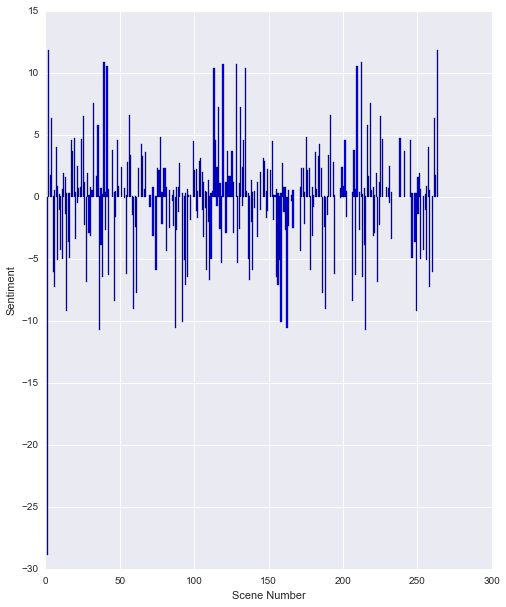

In [6]:
import numpy as np
from scipy.fftpack import fft
fftSentiment = fft(sentimentTrend['WeightedSentiment'])
plt.figure(figsize=(8, 10))
plt.bar(sentimentTrend.SeasonSceneCount, np.log(np.exp2(fftSentiment)),color="Blue")
plt.ylabel('Sentiment')
plt.xlabel('Scene Number')
plt.show()

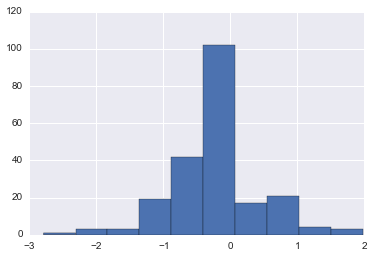

In [7]:
sentimentTrend['WeightedSentiment'].hist()

In [8]:
from sklearn import linear_model
import statsmodels.api as sm

In [9]:
model = sm.OLS(sentimentTrend.index,sentimentTrend['WeightedSentiment'] ).fit()

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     12.41
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           0.000521
Time:                        11:06:48   Log-Likelihood:                -1334.8
No. Observations:                 215   AIC:                             2672.
Df Residuals:                     214   BIC:                             2675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
WeightedSentiment   -41.9321     11.902     -3.523      0.001       -65.393   -18.472
==============================================================================
Omnibus:                        7.738   Durbin-Watson:                   0.099
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                5.391
Skew:                           0.253   Prob(JB):                       0.0675
Kurtosis:                       2.412   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
model.params

WeightedSentiment   -41.932148
dtype: float64

In [12]:
skReg = linear_model.LinearRegression(fit_intercept=True)
x = sentimentTrend.index.values
y = sentimentTrend.WeightedSentiment.values

In [13]:
skReg.fit(x[:,np.newaxis],y)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [14]:
skReg.coef_, skReg.intercept_

(array([ 0.00019713]), -0.21514448179628273)

In [15]:
sentimentTrend['WeightedSentiment'].mean()

-0.19405142354813926

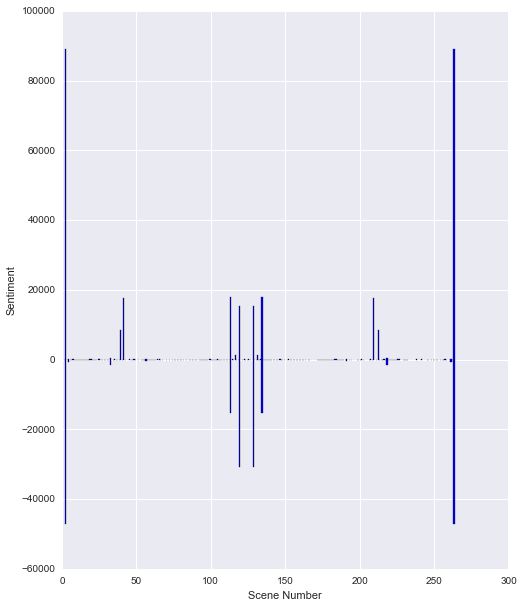

In [122]:
shiftY = sentimentTrend['WeightedSentiment'] - skReg.intercept_
fftSentimentShift = fft(sentimentTrend['WeightedSentiment'])
shiftYIFFT = fft(shiftY)
plt.figure(figsize=(8, 10))
plt.bar(sentimentTrend.SeasonSceneCount, np.exp2(fftSentimentShift),color="Blue")
plt.ylabel('Sentiment')
plt.xlabel('Scene Number')
plt.show()

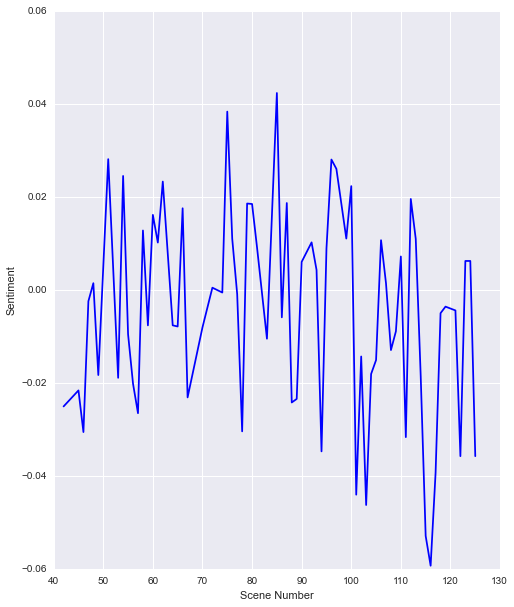

In [123]:
from scipy.fftpack import ifft

fftFiltered = pd.DataFrame(np.exp2(fftSentimentShift))
fftSentimentI = ifft((fftFiltered[0].apply(lambda x: abs(x) > np.sqrt(5000) and x < np.sqrt(40000))))

plt.figure(figsize=(8, 10))
plt.plot(sentimentTrend.SeasonSceneCount[40:110], fftSentimentI[40:110] ,color="Blue")
plt.ylabel('Sentiment')
plt.xlabel('Scene Number')
plt.show()

In [18]:
from statsmodels.graphics.api import qqplot
sentimentTrendARMA = sentimentTrend.set_index('SeasonSceneCount')['WeightedSentiment']

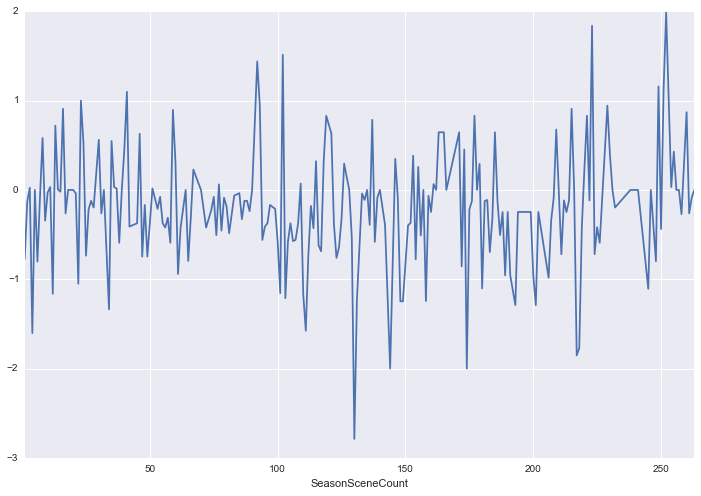

In [19]:
sentimentTrendARMA.plot(figsize=(12,8))

In [20]:
sm.stats.durbin_watson(sentimentTrendARMA)

1.6971578523558073

/Users/dheepan.ramanan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


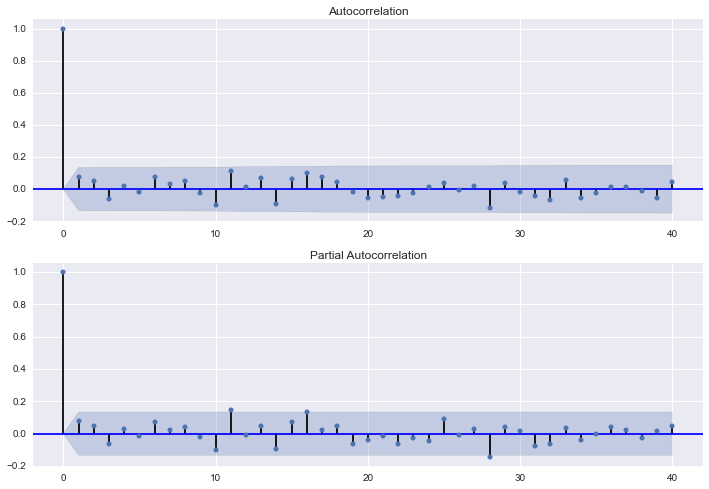

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentimentTrend['WeightedSentiment'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentimentTrend['WeightedSentiment'], lags=40, ax=ax2)

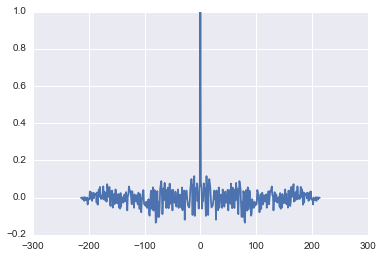

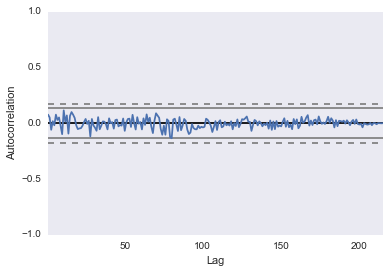

In [22]:
from pandas.tools.plotting import autocorrelation_plot
sentimentTrend['WSent'] = sentimentTrend['WeightedSentiment']
sentimentTrend['WSent'] = (sentimentTrend['WSent'] - sentimentTrend['WSent'].mean()) / (sentimentTrend['WSent'].std())
plt.acorr(sentimentTrend['WSent'],maxlags = len(sentimentTrend['WSent']) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(sentimentTrend['WeightedSentiment'])
plt.show()



In [23]:
sentimentTrend.index = pd.to_datetime(sentimentTrend.index, unit='ms')
arma_mod20 = sm.tsa.ARMA(sentimentTrend['WeightedSentiment'], (2,0)).fit()
print arma_mod20.params

const                     -0.194251
ar.L1.WeightedSentiment    0.073171
ar.L2.WeightedSentiment    0.045188
dtype: float64


In [24]:
print arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic

439.631005256 453.113557368 445.078578975


In [25]:
sm.stats.durbin_watson(arma_mod20.resid.values)

1.98979957656625

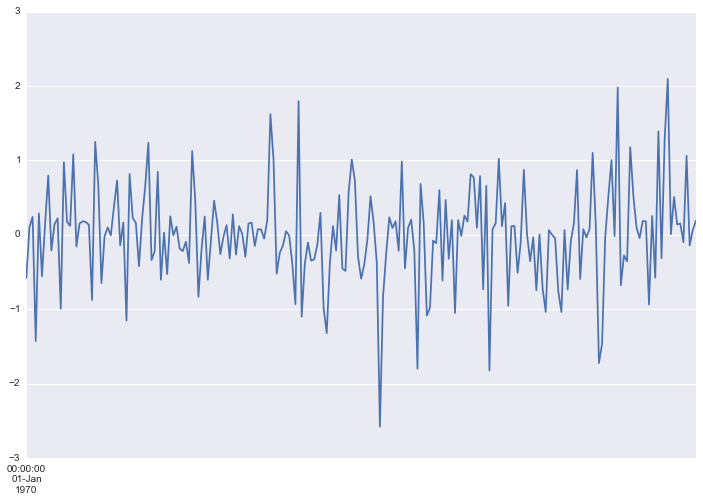

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);

In [27]:
resid20 = arma_mod20.resid
scipy.stats.mstats.normaltest(resid20)

NormaltestResult(statistic=10.783693185406111, pvalue=0.0045535570022233896)

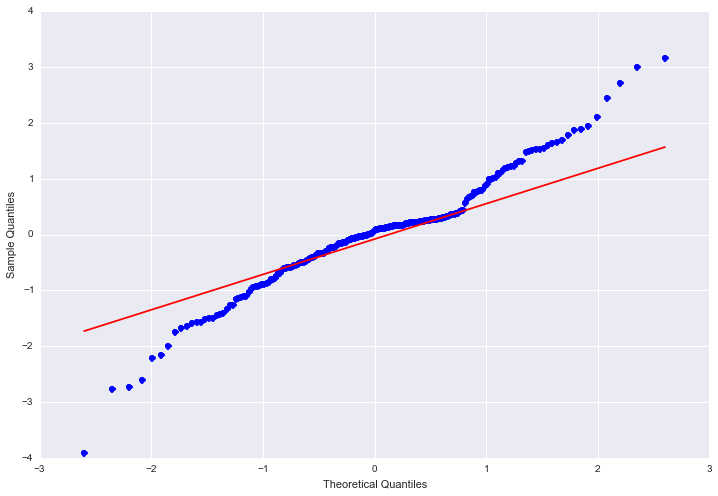

In [28]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid20, line='q', ax=ax, fit=True)

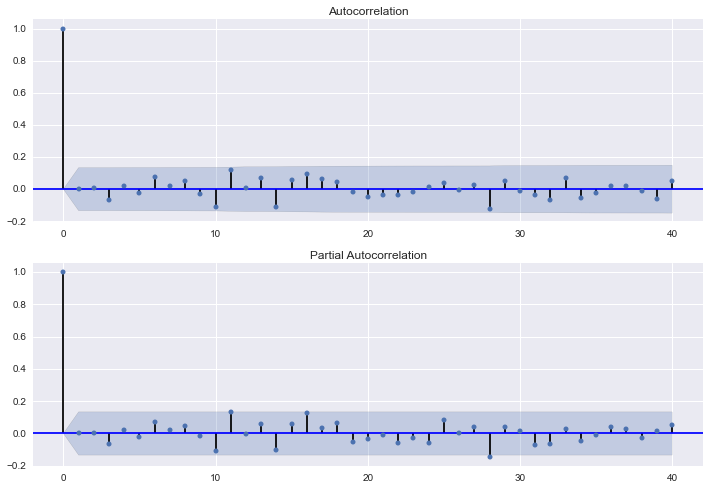

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20, lags=40, ax=ax2)

In [30]:
r,q,p = sm.tsa.acf(resid20.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print table.set_index('lag')

           AC          Q  Prob(>Q)
lag                               
1    0.003122   0.002125  0.963233
2    0.004254   0.006088  0.996960
3   -0.067597   1.011655  0.798432
4    0.018169   1.084645  0.896701
5   -0.024145   1.214169  0.943511
6    0.073934   2.434383  0.875738
7    0.022605   2.548995  0.923363
8    0.053009   3.182330  0.922399
9   -0.027375   3.352058  0.948689
10  -0.108929   6.052494  0.810834
11   0.121617   9.435158  0.581792
12   0.009356   9.455277  0.663630
13   0.068446  10.537318  0.649516
14  -0.109472  13.319030  0.501571
15   0.059455  14.143644  0.514664
16   0.093345  16.186466  0.440024
17   0.065024  17.182738  0.442054
18   0.041841  17.597344  0.482459
19  -0.020264  17.695085  0.542884
20  -0.049160  18.273301  0.569410
21  -0.038608  18.631773  0.608748
22  -0.038117  18.983002  0.646378
23  -0.020645  19.086571  0.696189
24   0.012610  19.125416  0.745268
25   0.038263  19.484924  0.773296
26  -0.005322  19.491916  0.815003
27   0.027683  19.68

In [88]:
from statsmodels.tsa.arima_model import ARIMA
arima_mod202 = sm.tsa.ARIMA(sentimentTrend['WeightedSentiment']- skReg.intercept_, (2,0,2)).fit()

In [81]:
arima_mod202.params

const                      0.021264
ar.L1.WeightedSentiment   -0.009588
ar.L2.WeightedSentiment   -0.989580
ma.L1.WeightedSentiment    0.020223
ma.L2.WeightedSentiment    1.000000
dtype: float64

In [82]:
arima_mod20.aic, arima_mod20.bic, arima_mod20.hqic

(444.5146689336801, 464.7384971024461, 452.68602951241547)

In [83]:
sm.stats.durbin_watson(arima_mod20.resid.values)

1.8637288616085554

In [84]:
resid202 = arima_mod202.resid
scipy.stats.mstats.normaltest(resid202)

NormaltestResult(statistic=11.328200441227825, pvalue=0.0034682670443733576)

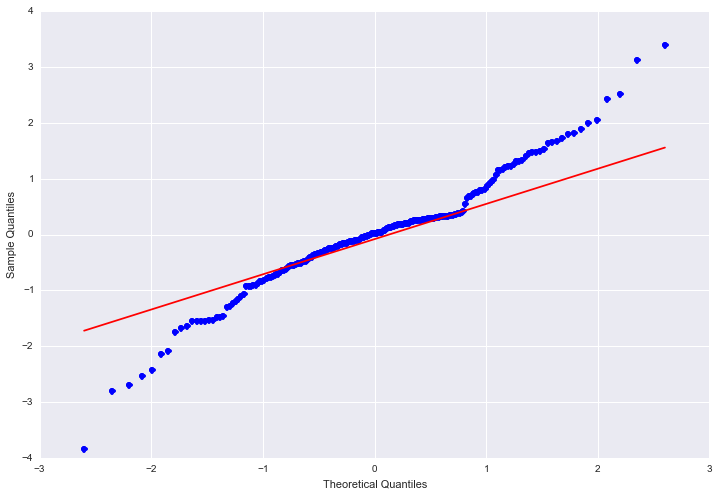

In [85]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid202, line='q', ax=ax, fit=True)

In [79]:
r,q,p = sm.tsa.acf(resid202.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print table.set_index('lag')

           AC          Q  Prob(>Q)
lag                               
1    0.003152   0.002166  0.962878
2   -0.017327   0.067923  0.966609
3   -0.025526   0.211319  0.975742
4   -0.005590   0.218228  0.994463
5   -0.007637   0.231187  0.998741
6    0.063981   1.144983  0.979515
7    0.024071   1.274948  0.989098
8    0.053975   1.931572  0.983038
9   -0.025679   2.080914  0.990122
10  -0.108885   4.779171  0.905433
11   0.122633   8.218581  0.693600
12   0.008605   8.235598  0.766459
13   0.068209   9.310164  0.749136
14  -0.106342  11.935078  0.611517
15   0.056190  12.671609  0.627646
16   0.099155  14.976636  0.526350
17   0.055270  15.696446  0.545447
18   0.047771  16.236895  0.576018
19  -0.023722  16.370843  0.632410
20  -0.045266  16.861077  0.661975
21  -0.039871  17.243383  0.696251
22  -0.033508  17.514797  0.734337
23  -0.026429  17.684533  0.774369
24   0.018260  17.765975  0.814211
25   0.030138  17.989013  0.842857
26   0.000085  17.989015  0.876173
27   0.025399  18.14